
## Get Requirements

In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
from torchvision import transforms, datasets
import torch.nn as nn
from torch import optim as optim
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path
import torch
from torch.utils import data
import math
import random
from torch.utils.data import Dataset, DataLoader
import time
import glob
import scipy.signal
import os
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
print(torch.__version__)


from datasets.sleep_edf import split_data, SleepEDF_MultiChan_Dataset
from models.epoch_cmt import Epoch_Cross_Transformer_Network
from models.sequence_cmt import Seq_Cross_Transformer_Network 
from utils.metrics import accuracy, kappa, g_mean, plot_confusion_matrix, confusion_matrix, AverageMeter 

1.10.0


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 
project_path = "mmsm/Experiments/testing"
if not os.path.isdir(project_path):
        os.makedirs(project_path)
        print(f"Project directory created at {project_path}")

### Neptune (Ignore this block)

In [4]:
is_neptune = False
if is_neptune:
    import neptune.new as neptune

    run = neptune.init(
        project="jathurshan0330/V2-Cros",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmYmRmNjE0Zi0xMDRkLTRlNzUtYmIxNi03NzM2ODBlZDc5NTMifQ==",
    )  # your credentials


In [5]:
 if is_neptune:
    experiment = "V2-Cros-76"   #Change This
    !mkdir "/home/jathu/fyp_g15_sleep_monitoring/Experiments/Sleep_edfx/V2-Cros-76"  # Change This

## Data

In [6]:
train_data_list = [0,1,2,3]  #4
val_data_list = [4]  #4
data_path = "/home/mmsm/Sleep_EDF_Dataset"

eeg_list = glob.glob(f'{data_path}/x*.h5')
eeg_list.sort()
[train_eeg_list, val_eeg_list] = split_data(eeg_list,train_data_list,val_data_list)
print(train_eeg_list)
print(val_eeg_list)

mean_eeg_list = glob.glob(f'{data_path}/mean*.h5')
mean_eeg_list.sort()
[train_mean_eeg_list, val_mean_eeg_list] = split_data(mean_eeg_list,train_data_list,val_data_list)
print(train_mean_eeg_list)
print(val_mean_eeg_list)

sd_eeg_list = glob.glob(f'{data_path}/std*.h5')
sd_eeg_list.sort()
[train_sd_eeg_list, val_sd_eeg_list] = split_data(sd_eeg_list,train_data_list,val_data_list)
print(train_sd_eeg_list)
print(val_sd_eeg_list)

#########################################################################################################################

eog_list = glob.glob(f'{data_path}/eog*.h5')
eog_list.sort()
[train_eog_list, val_eog_list] = split_data(eog_list,train_data_list,val_data_list)
print(train_eog_list)
print(val_eog_list)

mean_eog_list = glob.glob(f'{data_path}/eog_m*.h5')
mean_eog_list.sort()
[train_mean_eog_list, val_mean_eog_list] = split_data(mean_eog_list,train_data_list,val_data_list)
print(train_mean_eog_list)
print(val_mean_eog_list)

sd_eog_list = glob.glob(f'{data_path}/eog_s*.h5')
sd_eog_list.sort()
[train_sd_eog_list, val_sd_eog_list] = split_data(sd_eog_list,train_data_list,val_data_list)
print(train_sd_eog_list)
print(val_sd_eog_list)


label_list = glob.glob(f'{data_path}/y*.h5')
label_list.sort()
[train_label_list, val_label_list] = split_data(label_list,train_data_list,val_data_list)
print(train_label_list)
print(val_label_list)


['/home/mmsm/Sleep_EDF_Dataset/x1.h5' '/home/mmsm/Sleep_EDF_Dataset/x2.h5'
 '/home/mmsm/Sleep_EDF_Dataset/x3.h5' '/home/mmsm/Sleep_EDF_Dataset/x4.h5']
['/home/mmsm/Sleep_EDF_Dataset/x5.h5']
['/home/mmsm/Sleep_EDF_Dataset/mean1.h5'
 '/home/mmsm/Sleep_EDF_Dataset/mean2.h5'
 '/home/mmsm/Sleep_EDF_Dataset/mean3.h5'
 '/home/mmsm/Sleep_EDF_Dataset/mean4.h5']
['/home/mmsm/Sleep_EDF_Dataset/mean5.h5']
['/home/mmsm/Sleep_EDF_Dataset/std1.h5'
 '/home/mmsm/Sleep_EDF_Dataset/std2.h5'
 '/home/mmsm/Sleep_EDF_Dataset/std3.h5'
 '/home/mmsm/Sleep_EDF_Dataset/std4.h5']
['/home/mmsm/Sleep_EDF_Dataset/std5.h5']
['/home/mmsm/Sleep_EDF_Dataset/eog1.h5'
 '/home/mmsm/Sleep_EDF_Dataset/eog2.h5'
 '/home/mmsm/Sleep_EDF_Dataset/eog3.h5'
 '/home/mmsm/Sleep_EDF_Dataset/eog4.h5']
['/home/mmsm/Sleep_EDF_Dataset/eog5.h5']
['/home/mmsm/Sleep_EDF_Dataset/eog_m1.h5'
 '/home/mmsm/Sleep_EDF_Dataset/eog_m2.h5'
 '/home/mmsm/Sleep_EDF_Dataset/eog_m3.h5'
 '/home/mmsm/Sleep_EDF_Dataset/eog_m4.h5']
['/home/mmsm/Sleep_EDF_Dataset

In [7]:
train_dataset = SleepEDF_MultiChan_Dataset(eeg_file = train_eeg_list , 
                                           eog_file = train_eog_list, 
                                           label_file = train_label_list, 
                                           device = device, mean_eeg_l = train_mean_eeg_list, sd_eeg_l = train_sd_eeg_list, 
                                           mean_eog_l = train_mean_eog_list, sd_eog_l = train_sd_eog_list, 
                                           sub_wise_norm = True, 
                                           transform=transforms.Compose([
                                               transforms.ToTensor(),
                                                ]) )

val_dataset = SleepEDF_MultiChan_Dataset(eeg_file = val_eeg_list ,
                                         eog_file = val_eog_list, 
                                         label_file = val_label_list, 
                                         device = device, mean_eeg_l = val_mean_eeg_list, sd_eeg_l = val_sd_eeg_list,
                                         mean_eog_l = val_mean_eog_list, sd_eog_l = val_sd_eog_list,
                                         sub_wise_norm = True,
                                         transform=transforms.Compose([
                                               transforms.ToTensor(),
                                                ]) )

Reading from /home/mmsm/Sleep_EDF_Dataset/x1.h5 ====================================================
Keys in the h5py file : <KeysViewHDF5 ['x']>
Number of samples : 43754
Shape of each data : (43754, 1, 3000)
Reading from /home/mmsm/Sleep_EDF_Dataset/eog1.h5 ====================================================
Keys in the h5py file : <KeysViewHDF5 ['eog']>
Number of samples : 43754
Shape of each data : (43754, 1, 3000)
Reading from /home/mmsm/Sleep_EDF_Dataset/y1.h5 ====================================================
Keys in the h5py file : <KeysViewHDF5 ['y']>
Number of samples : 43754
Shape of each data : (43754,)
Reading from /home/mmsm/Sleep_EDF_Dataset/x2.h5 ====================================================
Keys in the h5py file : <KeysViewHDF5 ['x']>
Number of samples : 40155
Shape of each data : (40155, 1, 3000)
Reading from /home/mmsm/Sleep_EDF_Dataset/eog2.h5 ====================================================
Keys in the h5py file : <KeysViewHDF5 ['eog']>
Number of samp

In [8]:
batch_size = 64
train_data_loader = data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_data_loader = data.DataLoader(val_dataset, batch_size = 32, shuffle = True)

EEG batch shape: torch.Size([64, 1, 1, 3000])
EOG batch shape: torch.Size([64, 1, 1, 3000])
Labels batch shape: torch.Size([64])


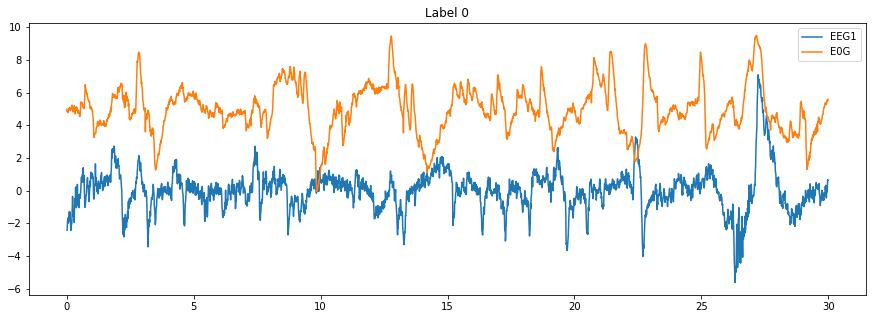

EEG batch shape: torch.Size([32, 1, 1, 3000])
EOG batch shape: torch.Size([32, 1, 1, 3000])
Labels batch shape: torch.Size([32])


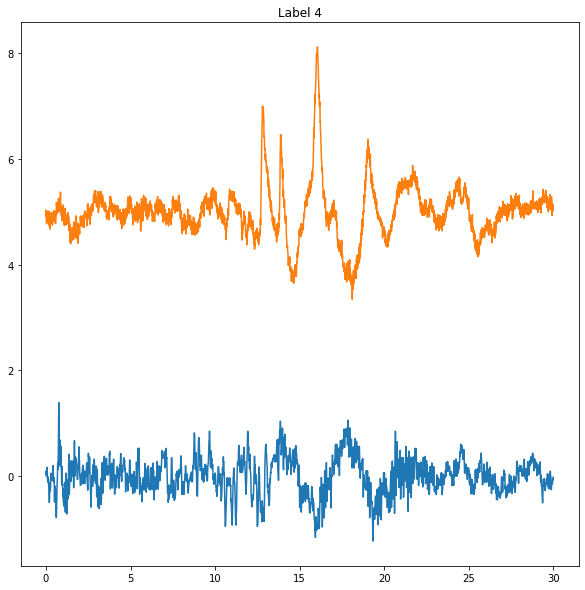

EEG Minimum :-5.9242736939407035
EEG Maximum :7.373364648818294
EOG Minimum :-9.597861970446278
EOG Maximum :9.308358448596389
EEG Mean :0.0014975272005030812
EEG Standard Deviation :0.9427593302541899
EOG Mean :-0.00022797915340683813
EOG Standard Deviation :1.0004089582760118


In [9]:
eeg_data, eog_data, label = next(iter(train_data_loader))
print(f"EEG batch shape: {eeg_data.size()}")
print(f"EOG batch shape: {eog_data.size()}")
print(f"Labels batch shape: {label.size()}")

t = np.arange(0,30,1/100)
plt.figure(figsize = (15,5))
plt.plot(t,eeg_data[0].squeeze(),label="EEG1")
plt.plot(t,eog_data[0].squeeze()+5,label="E0G")
plt.title(f"Label {label[0].squeeze()}")
plt.legend()
plt.show()


eeg_data, eog_data, label = next(iter(val_data_loader))
print(f"EEG batch shape: {eeg_data.size()}")
print(f"EOG batch shape: {eog_data.size()}")
print(f"Labels batch shape: {label.size()}")

t = np.arange(0,30,1/100)
plt.figure(figsize = (10,10))
plt.plot(t,eeg_data[0].squeeze())
plt.plot(t,eog_data[0].squeeze()+5)
plt.title(f"Label {label[0].squeeze()}")
plt.show()


print(f"EEG Minimum :{eeg_data.min()}")
print(f"EEG Maximum :{eeg_data.max()}")
print(f"EOG Minimum :{eog_data.min()}")
print(f"EOG Maximum :{eog_data.max()}")


print(f"EEG Mean :{torch.mean(eeg_data)}")
print(f"EEG Standard Deviation :{torch.std(eeg_data)}")
print(f"EOG Mean :{torch.mean(eog_data)}")
print(f"EOG Standard Deviation :{torch.std(eog_data)}")



### Classification Model Cross Transformer

In [10]:
import torch.optim as optim

d_model = 256 
dim_feedforward=1024 
window_size = 50
Net = Epoch_Cross_Transformer_Network(d_model = d_model, dim_feedforward=dim_feedforward,
                                window_size = window_size ).to(device)
# Net = torch.load("/home/jathu/fyp_g15_sleep_monitoring/Experiments/Sleep_edfx/Pretraining/VCROSPRE-23/Net_2_best_loss1.pth.tar")

lr = 0.001
beta_1 =  0.9    
beta_2 =  0.999    
eps = 1e-9
n_epochs = 1000
weights = torch.tensor([1., 2., 1., 2., 2.])
print(f"weights: {weights}")
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(Net.parameters(), lr=lr, betas=(beta_1, beta_2),eps = eps, weight_decay = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5) 
pred,cls_outs,feat_list = Net(eeg_data.float().to(device), eog_data.float().to(device),finetune = True)
print(pred.shape,cls_outs.shape,len(feat_list))

weights: tensor([1., 2., 1., 2., 2.])
torch.Size([32, 5]) torch.Size([32, 1, 512]) 3


In [11]:
if is_neptune:
    parameters = {
        "Experiment" : "Training test",
        'Model Type' : "Epoch Cross-Modal Transformer",
        'd_model' : d_model,
        'dim_feedforward' : dim_feedforward,
        'window_size ':window_size ,
        'Batch Size': batch_size,
        'Loss': f"Weighted Categorical Loss,{weights}",  # Check this every time
        'Optimizer' : "Adam",        # Check this every time   
        'Learning Rate': lr,
        'eps' : eps,
        "LR Schduler": "StepLR",
        'Beta 1': beta_1,
        'Beta 2': beta_2,
        'n_epochs': n_epochs,
        'val_set' : val_data_list[0]+1,
        'threshold': 0.5
    }
    run['model/parameters'] = parameters
    run['model/model_architecture'] = Net

### Training

In [ ]:
# Training the model
best_val_acc = 0
best_val_kappa = 0
for epoch_idx in range(n_epochs):  # loop over the dataset multiple times
    if is_neptune:
        run['train/epoch/learning_Rate'].log(optimizer.param_groups[0]["lr"]) 
    Net.train()
    print(f'===========================================================Training Epoch : [{epoch_idx+1}/{n_epochs}] ===========================================================================================================>')
    batch_time = AverageMeter()
    data_time = AverageMeter()
    
    losses = AverageMeter()
    val_losses = AverageMeter()
    
    train_accuracy = AverageMeter()
    val_accuracy = AverageMeter()

    train_sensitivity = AverageMeter()
    val_sensitivity = AverageMeter()
    
    train_specificity = AverageMeter()
    val_specificity = AverageMeter()

    train_gmean = AverageMeter()
    val_gmean = AverageMeter()

    train_kappa = AverageMeter()
    val_kappa = AverageMeter()

    train_f1_score = AverageMeter()
    val_f1_score = AverageMeter()

    train_precision = AverageMeter()
    val_precision = AverageMeter()

    class1_sens = AverageMeter()
    class2_sens = AverageMeter()
    class3_sens = AverageMeter()
    class4_sens = AverageMeter()
    class5_sens = AverageMeter()

    class1_spec = AverageMeter()
    class2_spec = AverageMeter()
    class3_spec = AverageMeter()
    class4_spec = AverageMeter()
    class5_spec = AverageMeter()

    class1_f1 = AverageMeter()
    class2_f1 = AverageMeter()
    class3_f1 = AverageMeter()
    class4_f1 = AverageMeter()
    class5_f1 = AverageMeter()

    end = time.time()

    for batch_idx, data_input in enumerate(train_data_loader):
        data_time.update(time.time() - end)
        eeg,eog, labels = data_input
        cur_batch_size = len(eeg)
        
        optimizer.zero_grad()

        outputs,_,_ = Net(eeg.float().to(device), eog.float().to(device),finetune = True)

        loss = criterion(outputs.cpu(), labels)


        loss.backward()
        optimizer.step()
        
        losses.update(loss.data.item())
        train_accuracy.update(accuracy(outputs.cpu(), labels))

        _,_,_,_,sens,spec,f1, prec = confusion_matrix(outputs.cpu(), labels, 5, cur_batch_size)
        train_sensitivity.update(sens)
        train_specificity.update(spec)
        train_f1_score.update(f1)
        train_precision.update(prec)
        train_gmean.update(g_mean(sens, spec))
        train_kappa.update(kappa(outputs.cpu(), labels))
        
        if is_neptune:
            run['train/epoch/batch_loss'].log(losses.val)     #1
            run['train/epoch/batch_accuracy'].log(train_accuracy.val)
        
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()


        if batch_idx % 1000 == 0:
            
            msg = 'Epoch: [{0}/{3}][{1}/{2}]\t' \
                  'Train_Loss {loss.val:.5f} ({loss.avg:.5f})\t'\
                  'Train_Acc {train_acc.val:.5f} ({train_acc.avg:.5f})\t'\
                  'Train_G-Mean {train_gmean.val:.5f}({train_gmean.avg:.5f})\t'\
                  'Train_Kappa {train_kap.val:.5f}({train_kap.avg:.5f})\t'\
                  'Train_MF1 {train_mf1.val:.5f}({train_mf1.avg:.5f})\t'\
                  'Train_Precision {train_prec.val:.5f}({train_prec.avg:.5f})\t'\
                  'Train_Sensitivity {train_sens.val:.5f}({train_sens.avg:.5f})\t'\
                  'Train_Specificity {train_spec.val:.5f}({train_spec.avg:.5f})\t'\
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t' \
                  'Speed {speed:.1f} samples/s\t' \
                  'Data {data_time.val:.3f}s ({data_time.avg:.3f}s)\t'.format(
                      epoch_idx+1, batch_idx, len(train_data_loader),n_epochs, batch_time=batch_time,
                      speed=data_input[0].size(0)/batch_time.val,
                      data_time=data_time, loss=losses, train_acc = train_accuracy,
                      train_sens =train_sensitivity, train_spec = train_specificity, train_gmean = train_gmean,
                      train_kap = train_kappa, train_mf1 = train_f1_score, train_prec = train_precision)
            print(msg)


    #evaluation
    with torch.no_grad():
      Net.eval()
      for batch_val_idx, data_val in enumerate(val_data_loader):
        val_eeg,val_eog, val_labels = data_val
        cur_val_batch_size = len(val_eeg)
        pred,_,_ = Net(val_eeg.float().to(device), val_eog.float().to(device),finetune = True)

        val_loss = criterion(pred.cpu(), val_labels)#
        val_losses.update(val_loss.data.item())
        val_accuracy.update(accuracy(pred.cpu(), val_labels))

        sens_list,spec_list,f1_list,prec_list, sens,spec,f1,prec = confusion_matrix(pred.cpu(), val_labels,  5, cur_val_batch_size)
        val_sensitivity.update(sens)
        val_specificity.update(spec)
        val_f1_score.update(f1)
        val_precision.update(prec)
        val_gmean.update(g_mean(sens, spec))
        val_kappa.update(kappa(pred.cpu(), val_labels))

        class1_sens.update(sens_list[0])
        class2_sens.update(sens_list[1])
        class3_sens.update(sens_list[2])
        class4_sens.update(sens_list[3])
        class5_sens.update(sens_list[4])

        class1_spec.update(spec_list[0])
        class2_spec.update(spec_list[1])
        class3_spec.update(spec_list[2])
        class4_spec.update(spec_list[3])
        class5_spec.update(spec_list[4])

        class1_f1.update(f1_list[0])
        class2_f1.update(f1_list[1])
        class3_f1.update(f1_list[2])
        class4_f1.update(f1_list[3])
        class5_f1.update(f1_list[4])

      print(batch_val_idx)

     

      print(f'===========================================================Epoch : [{epoch_idx+1}/{n_epochs}]  Evaluation ===========================================================================================================>')
      print("Training Results : ")
      print(f"Training Loss     : {losses.avg}, Training Accuracy      : {train_accuracy.avg}, Training G-Mean      : {train_gmean.avg}") 
      print(f"Training Kappa      : {train_kappa.avg},Training MF1     : {train_f1_score.avg}, Training Precision      : {train_precision.avg}, Training Sensitivity      : {train_sensitivity.avg}, Training Specificity      : {train_specificity.avg}")
      
      print("Validation Results : ")
      print(f"Validation Loss   : {val_losses.avg}, Validation Accuracy : {val_accuracy.avg}, Validation G-Mean      : {val_gmean.avg}") 
      print(f"Validation Kappa     : {val_kappa.avg}, Validation MF1      : {val_f1_score.avg}, Validation Precision      : {val_precision.avg},  Validation Sensitivity      : {val_sensitivity.avg}, Validation Specificity      : {val_specificity.avg}")
    

      print(f"Class wise sensitivity W: {class1_sens.avg}, S1: {class2_sens.avg}, S2: {class3_sens.avg}, S3: {class4_sens.avg}, R: {class5_sens.avg}")
      print(f"Class wise specificity W: {class1_spec.avg}, S1: {class2_spec.avg}, S2: {class3_spec.avg}, S3: {class4_spec.avg}, R: {class5_spec.avg}")
      print(f"Class wise F1  W: {class1_f1.avg}, S1: {class2_f1.avg}, S2: {class3_f1.avg}, S3: {class4_f1.avg}, R: {class5_f1.avg}")

      if is_neptune:
        run['train/epoch/epoch_train_loss'].log(losses.avg)
        run['train/epoch/epoch_val_loss'].log(val_losses.avg)

        run['train/epoch/epoch_train_accuracy'].log(train_accuracy.avg)
        run['train/epoch/epoch_val_accuracy'].log(val_accuracy.avg)

        run['train/epoch/epoch_train_sensitivity'].log(train_sensitivity.avg)
        run['train/epoch/epoch_val_sensitivity'].log(val_sensitivity.avg)

        run['train/epoch/epoch_train_specificity'].log(train_specificity.avg)
        run['train/epoch/epoch_val_specificity'].log(val_specificity.avg)

        run['train/epoch/epoch_train_G-Mean'].log(train_gmean.avg)
        run['train/epoch/epoch_val_G-Mean'].log(val_gmean.avg)

        run['train/epoch/epoch_train_Kappa'].log(train_kappa.avg)
        run['train/epoch/epoch_val_Kappa'].log(val_kappa.avg)

        run['train/epoch/epoch_train_MF1 Score'].log(train_f1_score.avg)
        run['train/epoch/epoch_val_MF1 Score'].log(val_f1_score.avg)

        run['train/epoch/epoch_train_Precision'].log(train_precision.avg)
        run['train/epoch/epoch_val_Precision'].log(val_precision.avg)

        #################################

        run['train/epoch/epoch_val_Class wise sensitivity W'].log(class1_sens.avg)
        run['train/epoch/epoch_val_Class wise sensitivity S1'].log(class2_sens.avg)
        run['train/epoch/epoch_val_Class wise sensitivity S2'].log(class3_sens.avg)
        run['train/epoch/epoch_val_Class wise sensitivity S3'].log(class4_sens.avg)
        run['train/epoch/epoch_val_Class wise sensitivity R'].log(class5_sens.avg)

        run['train/epoch/epoch_val_Class wise specificity W'].log(class1_spec.avg)
        run['train/epoch/epoch_val_Class wise specificity S1'].log(class2_spec.avg)
        run['train/epoch/epoch_val_Class wise specificity S2'].log(class3_spec.avg)
        run['train/epoch/epoch_val_Class wise specificity S3'].log(class4_spec.avg)
        run['train/epoch/epoch_val_Class wise specificity R'].log(class5_spec.avg)

        run['train/epoch/epoch_val_Class wise F1 Score W'].log(class1_f1.avg)
        run['train/epoch/epoch_val_Class wise F1 Score S1'].log(class2_f1.avg)
        run['train/epoch/epoch_val_Class wise F1 Score S2'].log(class3_f1.avg)
        run['train/epoch/epoch_val_Class wise F1 Score S3'].log(class4_f1.avg)
        run['train/epoch/epoch_val_Class wise F1 Score R'].log(class5_f1.avg)

      if val_accuracy.avg > best_val_acc or (epoch_idx+1)%100==0 or val_kappa.avg > best_val_kappa:
          if val_accuracy.avg > best_val_acc:
            best_val_acc = val_accuracy.avg
            print("================================================================================================")
            print("                                          Saving Best Model (ACC)                                     ")
            print("================================================================================================")
            torch.save(Net, f'{project_path}/checkpoint_model_best_acc.pth.tar')
          if val_kappa.avg > best_val_kappa:
            best_val_kappa = val_kappa.avg
            print("================================================================================================")
            print("                                          Saving Best Model (Kappa)                                    ")
            print("================================================================================================")
            torch.save(Net, f'{project_path}/checkpoint_model_best_kappa.pth.tar')
          if (epoch_idx+1)%50==0:
            torch.save(Net, f'{project_path}/checkpoint_model_epoch_{epoch_idx+1}.pth.tar')
    lr_scheduler.step()
         
print('========================================Finished Training ===========================================')

===========================================================Training Epoch : [1/1000] ===========================================================================================================>
Epoch: [1/1000][0/2496]	Train_Loss 1.87022 (1.87022)	Train_Acc 0.12500 (0.12500)	Train_G-Mean 0.45154(0.45154)	Train_Kappa 0.05160(0.05160)	Train_MF1 0.10677(0.10677)	Train_Precision 0.31053(0.31053)	Train_Sensitivity 0.25072(0.25072)	Train_Specificity 0.81319(0.81319)	Time 0.261s (0.261s)	Speed 245.1 samples/s	Data 0.067s (0.067s)	
Epoch: [1/1000][1000/2496]	Train_Loss 0.74587 (0.89480)	Train_Acc 0.78125 (0.68073)	Train_G-Mean 0.81036(0.74815)	Train_Kappa 0.69586(0.56398)	Train_MF1 0.73147(0.57726)	Train_Precision 0.79762(0.59870)	Train_Sensitivity 0.69931(0.61316)	Train_Specificity 0.93905(0.91799)	Time 0.057s (0.062s)	Speed 1124.2 samples/s	Data 0.020s (0.023s)	
